In [1]:
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from dataandcoords import set_data_and_coords
from gpapproximation import make_gp_basis
from posteriorplots import predictive_plot, retrodictive_plot
from zerosumnormal import ZeroSumNormal

if pm.math.erf.__module__.split(".")[0] == "theano":
    import theano.tensor as aet
else:
    import aesara.tensor as aet

In [2]:
arviz.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

In [3]:
COORDS = {
    "parties": ["farleft", "left", "green", "center", "right", "farright"],
    "parties_complete": [
        "farleft",
        "left",
        "green",
        "center",
        "right",
        "farright",
        "other",
    ],
}

## Data

In [4]:
results, polls = set_data_and_coords()

/Users/alex_andorra/repos/pollsposition/models/presidential-elections/dataandcoords.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["countdown"] = dates_to_idx(df["date"], date).astype(int)


In [5]:
polls

date sondage dateelection  countdown  samplesize  farleft  left  \
0   2002-01-02     BVA   2002-04-21        109         919       64   221   
1   2002-01-03     CSA   2002-04-21        108         997       50   214   
2   2002-01-04   Ipsos   2002-04-21        107        5297      318  1218   
3   2002-01-05     BVA   2002-04-21        106         500       35   120   
4   2002-01-05  Kantar   2002-04-21        106         763       53   183   
..         ...     ...          ...        ...         ...      ...   ...   
431 2017-04-20   Elabe   2017-04-23          3        1196      233    84   
432 2017-04-20    Ifop   2017-04-23          3        1901      352   133   
433 2017-04-20   Ipsos   2017-04-23          3        1400      266   105   
434 2017-04-21     BVA   2017-04-23          2        1134      221    91   
435 2017-04-21   Odoxa   2017-04-23          2         667      127    50   

     green  center  right  farright  other  
0       64      46    193        92    239  
1       60      40    279       100    254  
2      265     212   1483       477   1324  
3       35      15    135        45    115  
4       46      23    206        69    183  
..     ...     ...    ...       ...    ...  
431      0     287    239       257     96  
432      0     466    370       428    152  
433      0     336    266       308    119  
434      0     261    215       261     85  
435      0     163    127       153     47  

[436 rows x 12 columns]

### Unpooled model

In [6]:
pollster_id, COORDS["pollsters"] = polls["sondage"].factorize(sort=True)
countdown_id, COORDS["countdown"] = polls.countdown.values, np.arange(
    polls.countdown.max() + 1
)
election_id, COORDS["elections"] = polls["dateelection"].factorize()
COORDS["observations"] = polls.index

In [12]:
GP_CONFIG = {
    "lengthscale": [5, 14, 28],
    "kernel": "gaussian",
    "zerosum": True,
    "variance_limit": 0.95,
    "variance_weight": [0.6, 0.3, 0.1],
}

In [33]:
with pm.Model(coords=COORDS) as plain_mult:
    intercept = ZeroSumNormal(
        "intercept", sigma=0.15, dims=("elections", "parties_complete"), zerosum_axes=-1
    )
    house_effects = ZeroSumNormal(
        "house_effects",
        sigma=0.1,
        dims=("pollsters", "parties_complete", "elections"),
        zerosum_axes=(0, 1),
    )

    lsd_intercept = pm.Normal("lsd_intercept", dims="elections")
    shrinkage = pm.HalfNormal("shrinkage", 0.1, dims="elections")
    raw_lsd = ZeroSumNormal(
        "raw_lsd_party", dims=("parties_complete", "elections"), zerosum_axes=0
    )
    sd = pm.Deterministic(
        "time_weight",
        aet.exp(lsd_intercept[None, :] + shrinkage[None, :] * raw_lsd),
        dims=("parties_complete", "elections"),
    )
    # shrinkage = pm.HalfNormal("shrinkage", 0.5)
    # sd = pm.HalfNormal("time_weight", shrinkage, dims="parties_complete")

    gp_basis_funcs, gp_basis_dim = make_gp_basis(
        time=COORDS["countdown"], gp_config=GP_CONFIG, key="parties"
    )
    raw_coefs = ZeroSumNormal(
        f"raw_time_coefs",
        sigma=sd[None, ...],
        dims=(gp_basis_dim, "parties_complete", "elections"),
        zerosum_axes=1,
    )
    gps = pm.Deterministic(
        "time_effect",
        aet.tensordot(gp_basis_funcs, raw_coefs, axes=(1, 0)),
        dims=("countdown", "parties_complete", "elections"),
    )

    # data
    election_idx = pm.Data("election_idx", election_id, dims="observations")
    pollster_idx = pm.Data("pollster_idx", pollster_id, dims="observations")
    countdown_idx = pm.Data("countdown_idx", countdown_id, dims="observations")
    observed_N = pm.Data("observed_N", polls["samplesize"].values, dims="observations")
    observed_polls = pm.Data(
        "observed_polls",
        polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    # regression
    popularity = pm.Deterministic(
        "popularity",
        aet.nnet.softmax(
            intercept[election_idx]
            + house_effects[pollster_idx, :, election_idx]
            + gps[countdown_idx, :, election_idx]
        ),
        dims=("observations", "parties_complete"),
    )

    # likelihood
    N_approve = pm.Multinomial(
        "N_approve",
        p=popularity,
        n=observed_N,
        observed=observed_polls,
        dims=("observations", "parties_complete"),
    )
    # https://mc-stan.org/docs/2_27/stan-users-guide/bayesian-measurement-error-model.html

    prior_checks = pm.sample_prior_predictive(
        var_names=["time_effect", "popularity", "N_approve"]
    )
    idata = pm.sample(return_inferencedata=True)
    post_checks = pm.sample_posterior_predictive(
        idata, var_names=["time_effect", "popularity", "N_approve"]
    )
    idata.extend(arviz.from_pymc3(prior=prior_checks, posterior_predictive=post_checks))

[autoreload of dataandcoords failed: Traceback (most recent call last):
  File "/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 790, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/alex_andorra/repos/pollspositi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 244 seconds.


0, dim: observations, 436 =? 436
1, dim: parties_complete, 1 =? 7


The number of effective samples is smaller than 25% for some parameters.


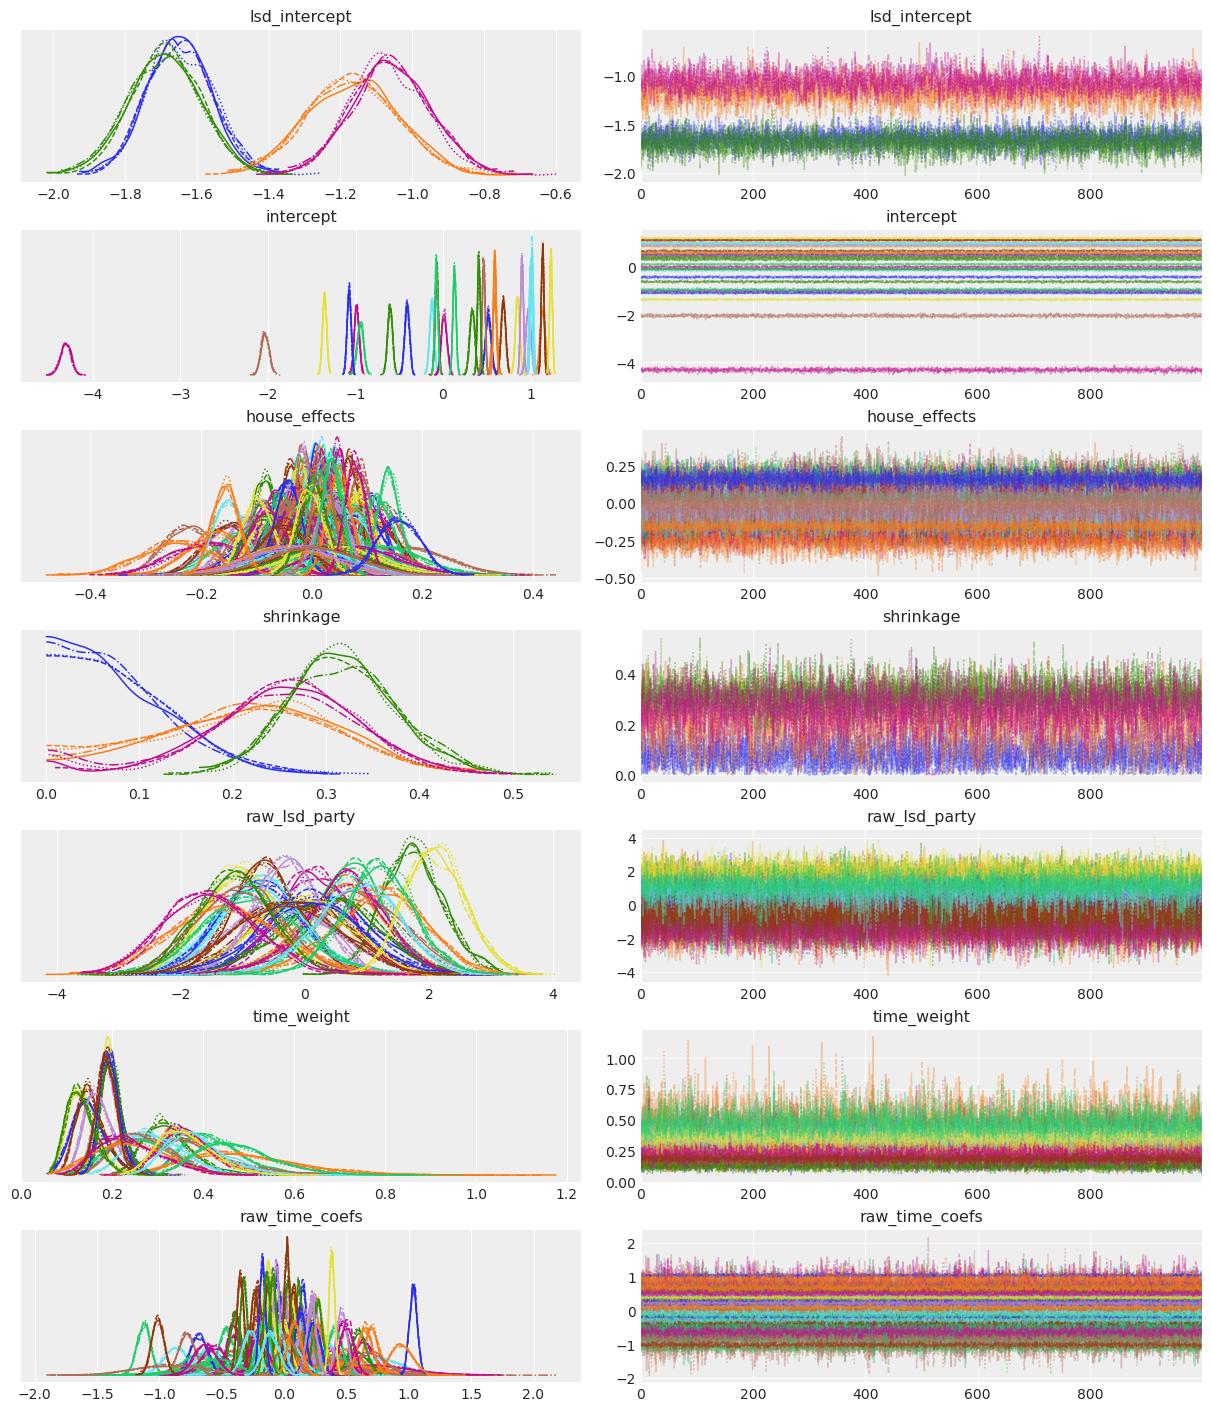

In [34]:
arviz.plot_trace(idata, var_names=["~time_effect", "~popularity"]);

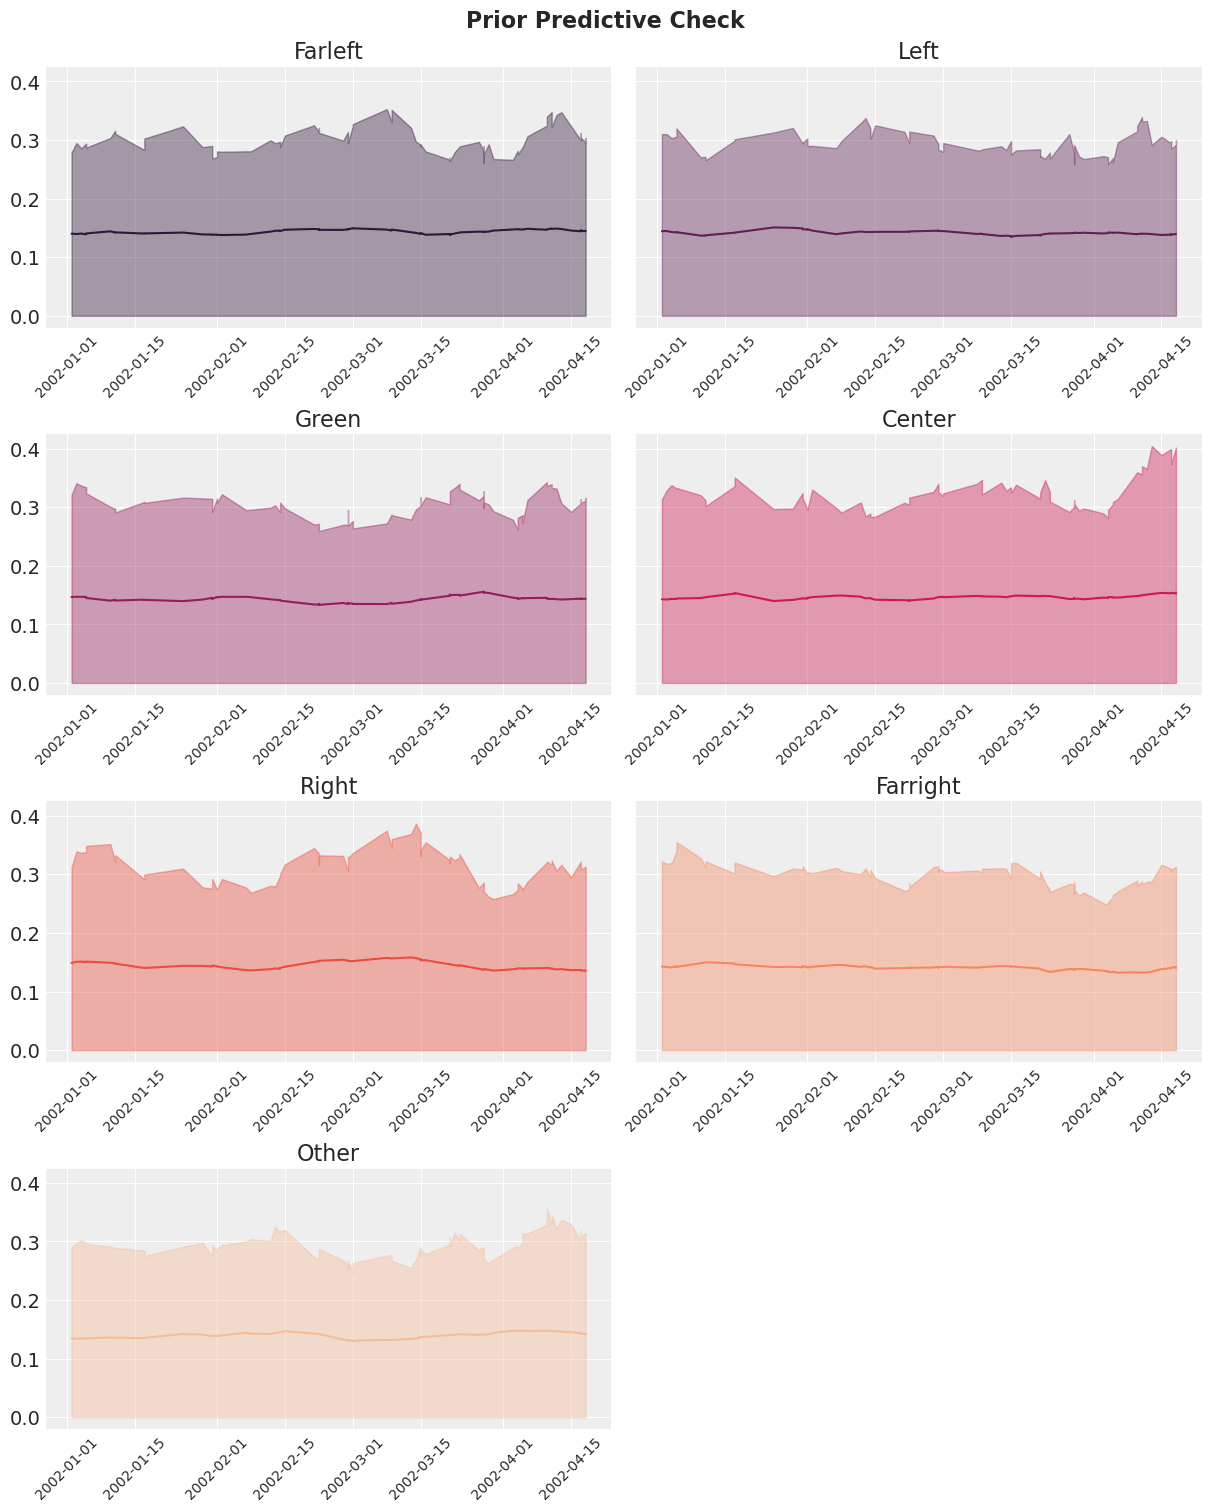

In [35]:
retrodictive_plot(
    idata.sel(
        elections="2002-04-21",
        observations=polls[polls.dateelection == "2002-04-21"].index,
    ),
    COORDS["parties_complete"],
    polls[polls.dateelection == "2002-04-21"],
    group="prior",
)

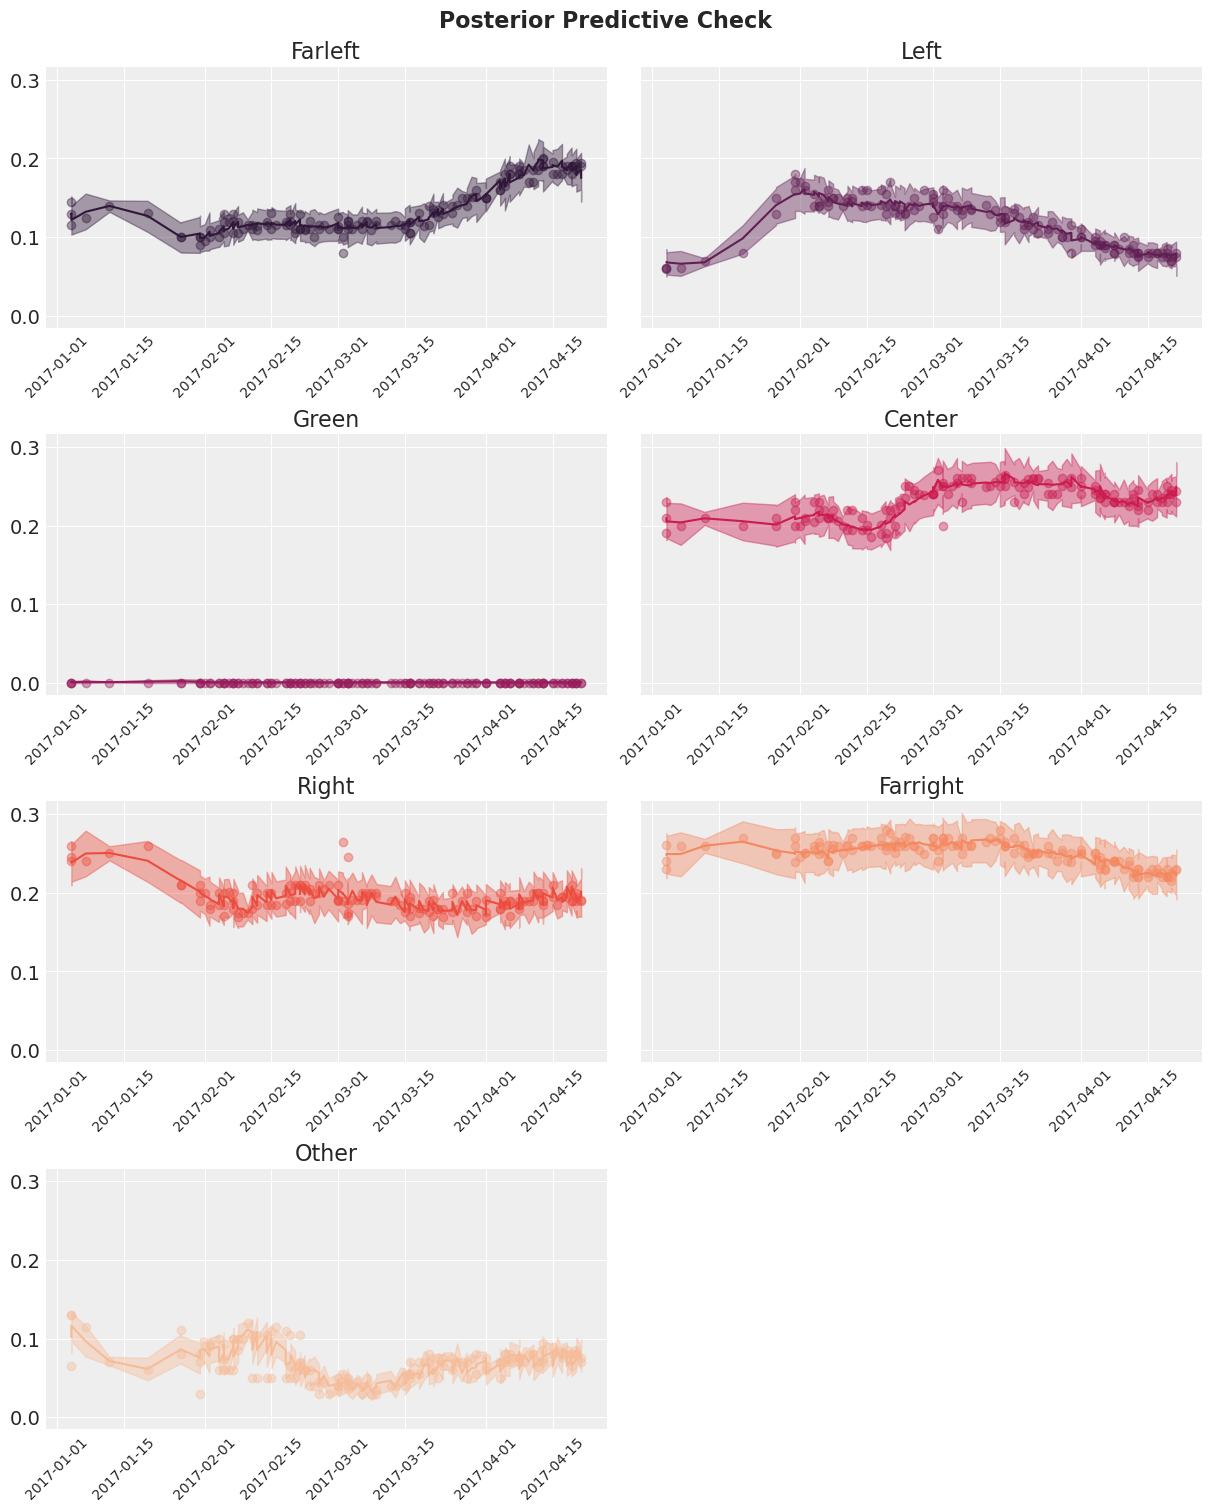

In [36]:
retrodictive_plot(
    idata.sel(
        elections="2017-04-23",
        observations=polls[polls.dateelection == "2017-04-23"].index,
    ),
    COORDS["parties_complete"],
    polls[polls.dateelection == "2017-04-23"],
    group="posterior",
)

In [37]:
estimated_days = np.tile(COORDS["countdown"][::-1], reps=len(COORDS["elections"]))

new_dates = []
for date in idata.posterior["elections"].data:
    new_dates.append(
        pd.date_range(
            periods=max(COORDS["countdown"]) + 1, end=date, freq="D"
        ).to_series()
    )

new_dates = pd.concat(new_dates).index

In [38]:
with plain_mult:
    pm.set_data(
        {
            "countdown_idx": estimated_days,
            "election_idx": np.repeat(
                np.arange(len(COORDS["elections"])), repeats=len(COORDS["countdown"])
            ),
            "pollster_idx": np.random.choice(pollster_id, size=len(estimated_days)),
            "observed_N": np.random.choice(
                polls["samplesize"].values, size=len(estimated_days)
            ),
            "observed_polls": np.ones(
                (len(estimated_days), len(COORDS["parties_complete"])), dtype=int
            ),  # just a placeholder
        }
    )
    ppc = pm.sample_posterior_predictive(
        idata, var_names=["time_effect", "popularity", "N_approve"]
    )

In [39]:
PREDICTION_COORDS = {"observations": new_dates}
PREDICTION_DIMS = {
    "time_effect": ["countdown", "parties_complete", "elections"],
    "popularity": ["observations", "parties_complete"],
    "N_approve": ["observations", "parties_complete"],
}

In [40]:
with plain_mult:
    arviz.from_pymc3_predictions(
        ppc,
        idata_orig=idata,
        inplace=True,
        coords=PREDICTION_COORDS,
        dims=PREDICTION_DIMS,
    )

In [21]:
%load_ext autoreload
%autoreload 2

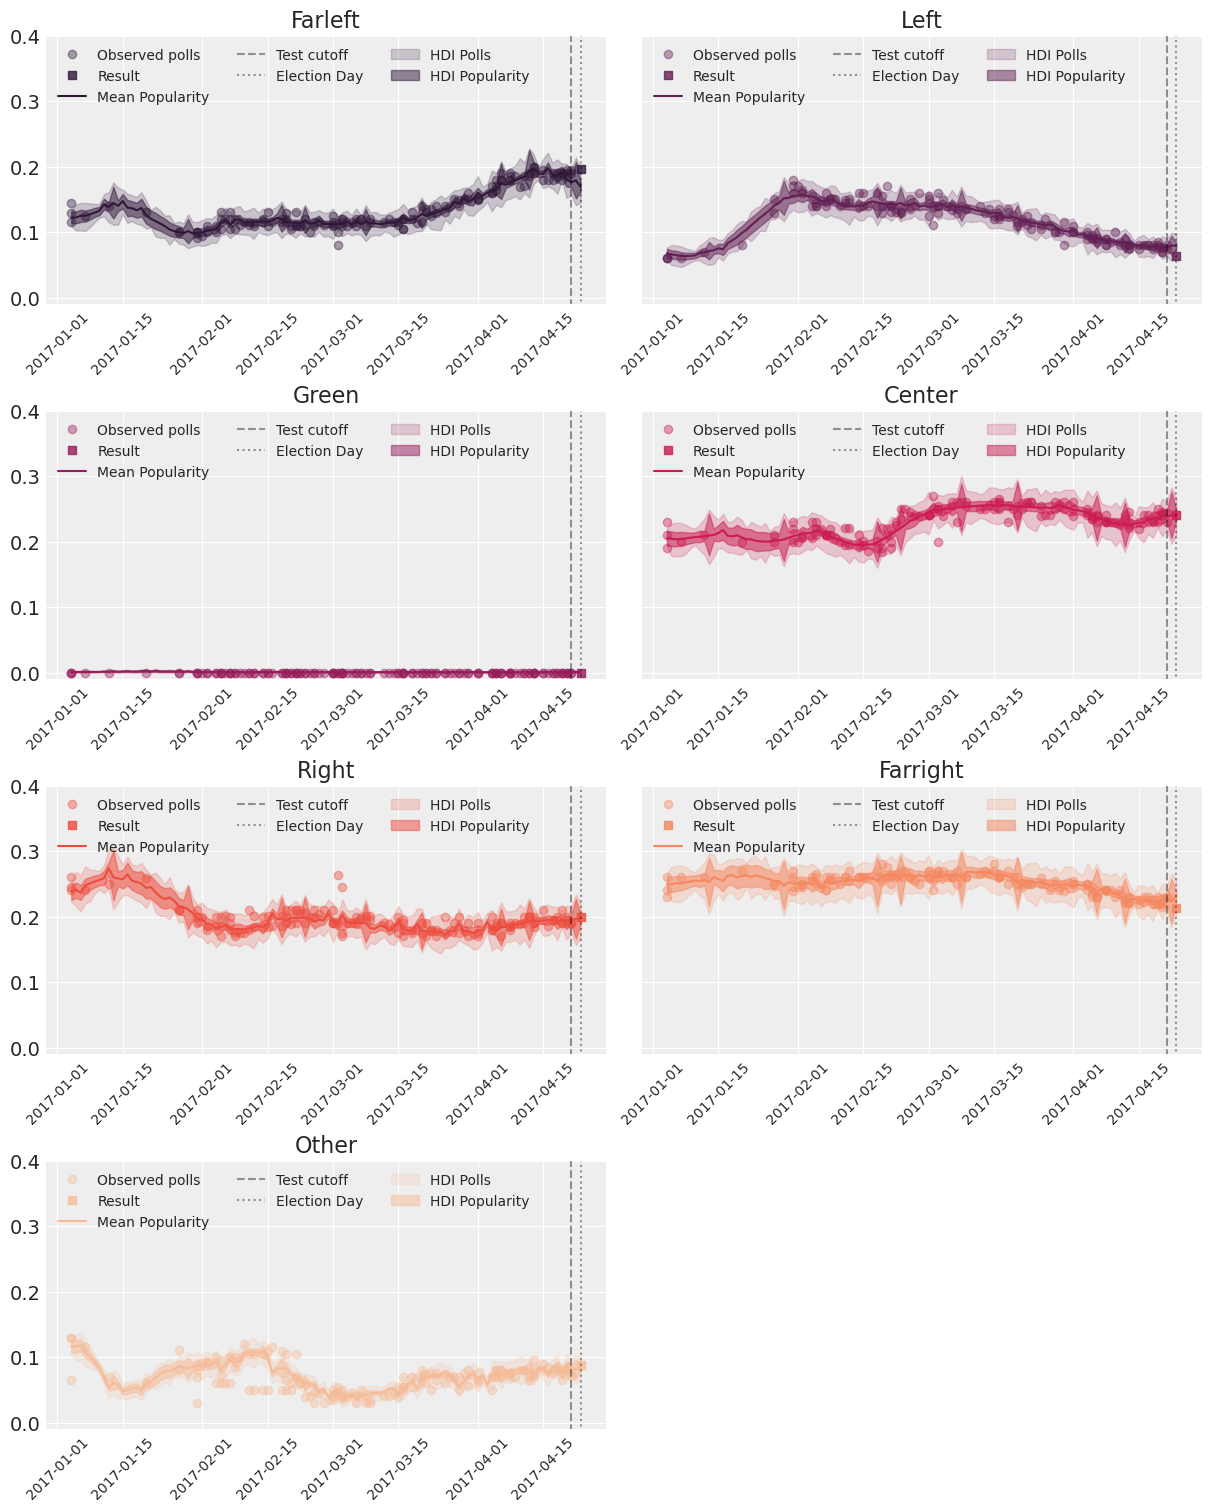

In [41]:
election_date = "2017-04-23"
polls_train = polls[polls.dateelection == election_date]
polls_test = pd.DataFrame()

predictive_plot(
    idata,
    COORDS["parties_complete"],
    election_date,
    results,
    polls_train,
    polls_test,
)

### Hierarchical model

In [124]:
GP_CONFIG = {
    "lengthscale": [7, 14, 28],
    "kernel": "gaussian",
    "zerosum": True,
    "variance_limit": 0.95,
    "variance_weight": [0.5, 0.3, 0.2],
}

In [ ]:
country_effect = pm.Normal(0, 1, dims="country")
country_std = pm.HalfNormal()
country_gender_effect = ZeroSumNormal(0, country_std, dims=("country", "gender"))
mu = intercept + country_effect + country_gender_effect

In [8]:
with pm.Model(coords=COORDS) as m_hierarchical:
    party_intercept = ZeroSumNormal(
        "party_intercept", sigma=0.15, dims="parties_complete"
    )
    party_shrinkage = pm.HalfNormal("party_shrinkage", 0.1)
    election_party_intercept = ZeroSumNormal(
        "election_party_intercept",
        sigma=party_shrinkage,
        dims=("elections", "parties_complete"),
        zerosum_axes=-1,
    )
    house_effects = ZeroSumNormal(
        "house_effects",
        sigma=0.1,
        dims=("pollsters", "parties_complete", "elections"),
        zerosum_axes=(0, 1),
    )

    lsd_intercept = pm.Normal("lsd_intercept", sigma=0.15, dims="elections")
    shrinkage = pm.HalfNormal("shrinkage", 0.1, dims="elections")
    raw_lsd = ZeroSumNormal(
        "raw_lsd_party", dims=("parties_complete", "elections"), zerosum_axes=0
    )
    sd = pm.Deterministic(
        "time_weight",
        aet.exp(lsd_intercept[None, :] + shrinkage[None, :] * raw_lsd),
        dims=("parties_complete", "elections"),
    )
    # shrinkage = pm.HalfNormal("shrinkage", 0.5)
    # sd = pm.HalfNormal("time_weight", shrinkage, dims="parties_complete")

    gp_basis_funcs, gp_basis_dim = make_gp_basis(
        time=COORDS["countdown"], gp_config=GP_CONFIG, key="parties"
    )
    raw_coefs = ZeroSumNormal(
        f"raw_time_coefs",
        sigma=sd[None, ...],
        dims=(gp_basis_dim, "parties_complete", "elections"),
        zerosum_axes=1,
    )
    gps = pm.Deterministic(
        "time_effect",
        aet.tensordot(gp_basis_funcs, raw_coefs, axes=(1, 0)),
        dims=("countdown", "parties_complete", "elections"),
    )

    # data
    election_idx = pm.Data("election_idx", election_id, dims="observations")
    pollster_idx = pm.Data("pollster_idx", pollster_id, dims="observations")
    countdown_idx = pm.Data("countdown_idx", countdown_id, dims="observations")
    observed_N = pm.Data("observed_N", polls["samplesize"].values, dims="observations")
    observed_polls = pm.Data(
        "observed_polls",
        polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    # regression
    popularity = pm.Deterministic(
        "popularity",
        aet.nnet.softmax(
            party_intercept
            + election_party_intercept[election_idx]
            + house_effects[pollster_idx, :, election_idx]
            + gps[countdown_idx, :, election_idx]
        ),
        dims=("observations", "parties_complete"),
    )

    # likelihood
    N_approve = pm.Multinomial(
        "N_approve",
        p=popularity,
        n=observed_N,
        observed=observed_polls,
        dims=("observations", "parties_complete"),
    )
    # https://mc-stan.org/docs/2_27/stan-users-guide/bayesian-measurement-error-model.html

    prior_checks = pm.sample_prior_predictive(
        var_names=["time_effect", "popularity", "N_approve"]
    )
    idata_hierarchical = pm.sample(return_inferencedata=True)
    post_checks = pm.sample_posterior_predictive(
        idata_hierarchical, var_names=["time_effect", "popularity", "N_approve"]
    )
    idata_hierarchical.extend(
        arviz.from_pymc3(prior=prior_checks, posterior_predictive=post_checks)
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_time_coefs, raw_lsd_party, shrinkage, lsd_intercept, house_effects, election_party_intercept, party_shrinkage, party_intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1033 seconds.


0, dim: observations, 436 =? 436
1, dim: parties_complete, 1 =? 7


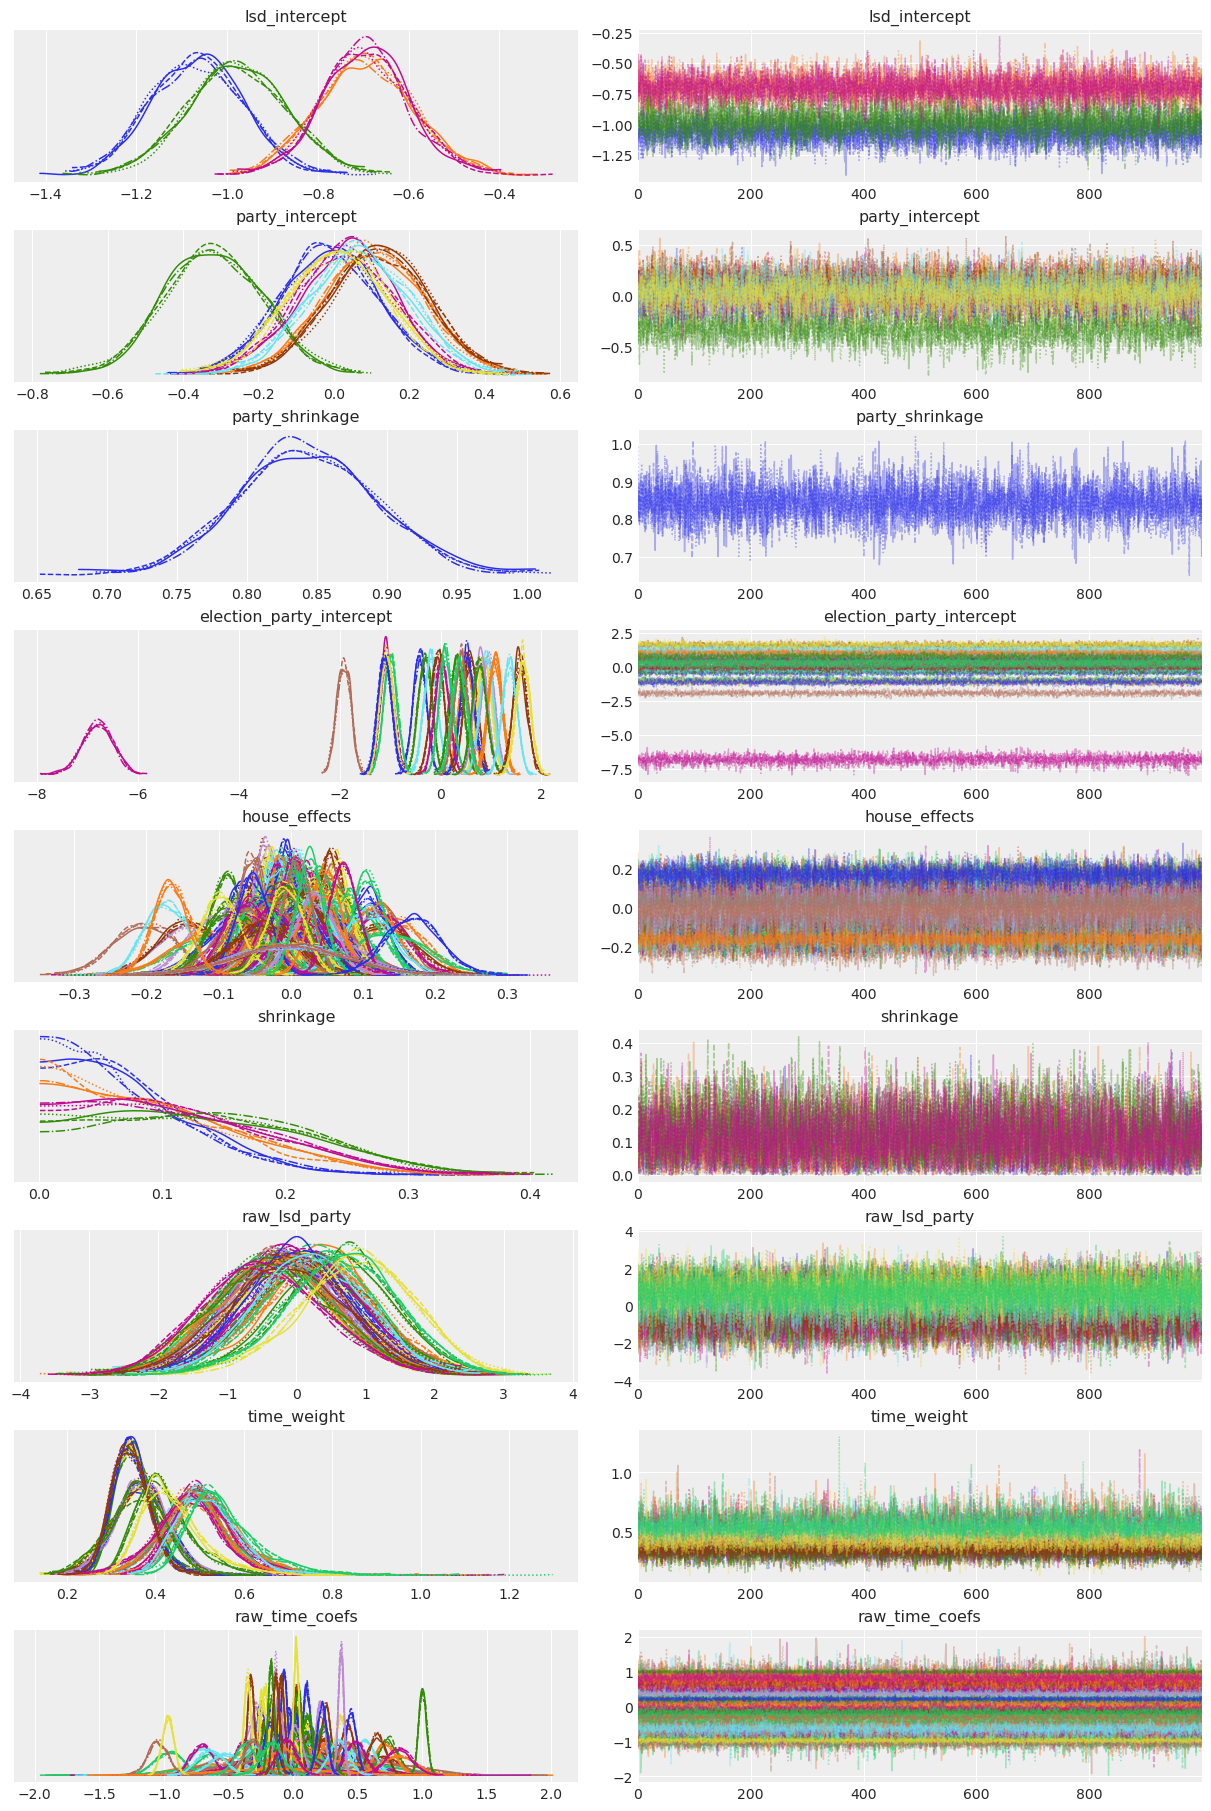

In [12]:
arviz.plot_trace(idata_hierarchical, var_names=["~time_effect", "~popularity"]);

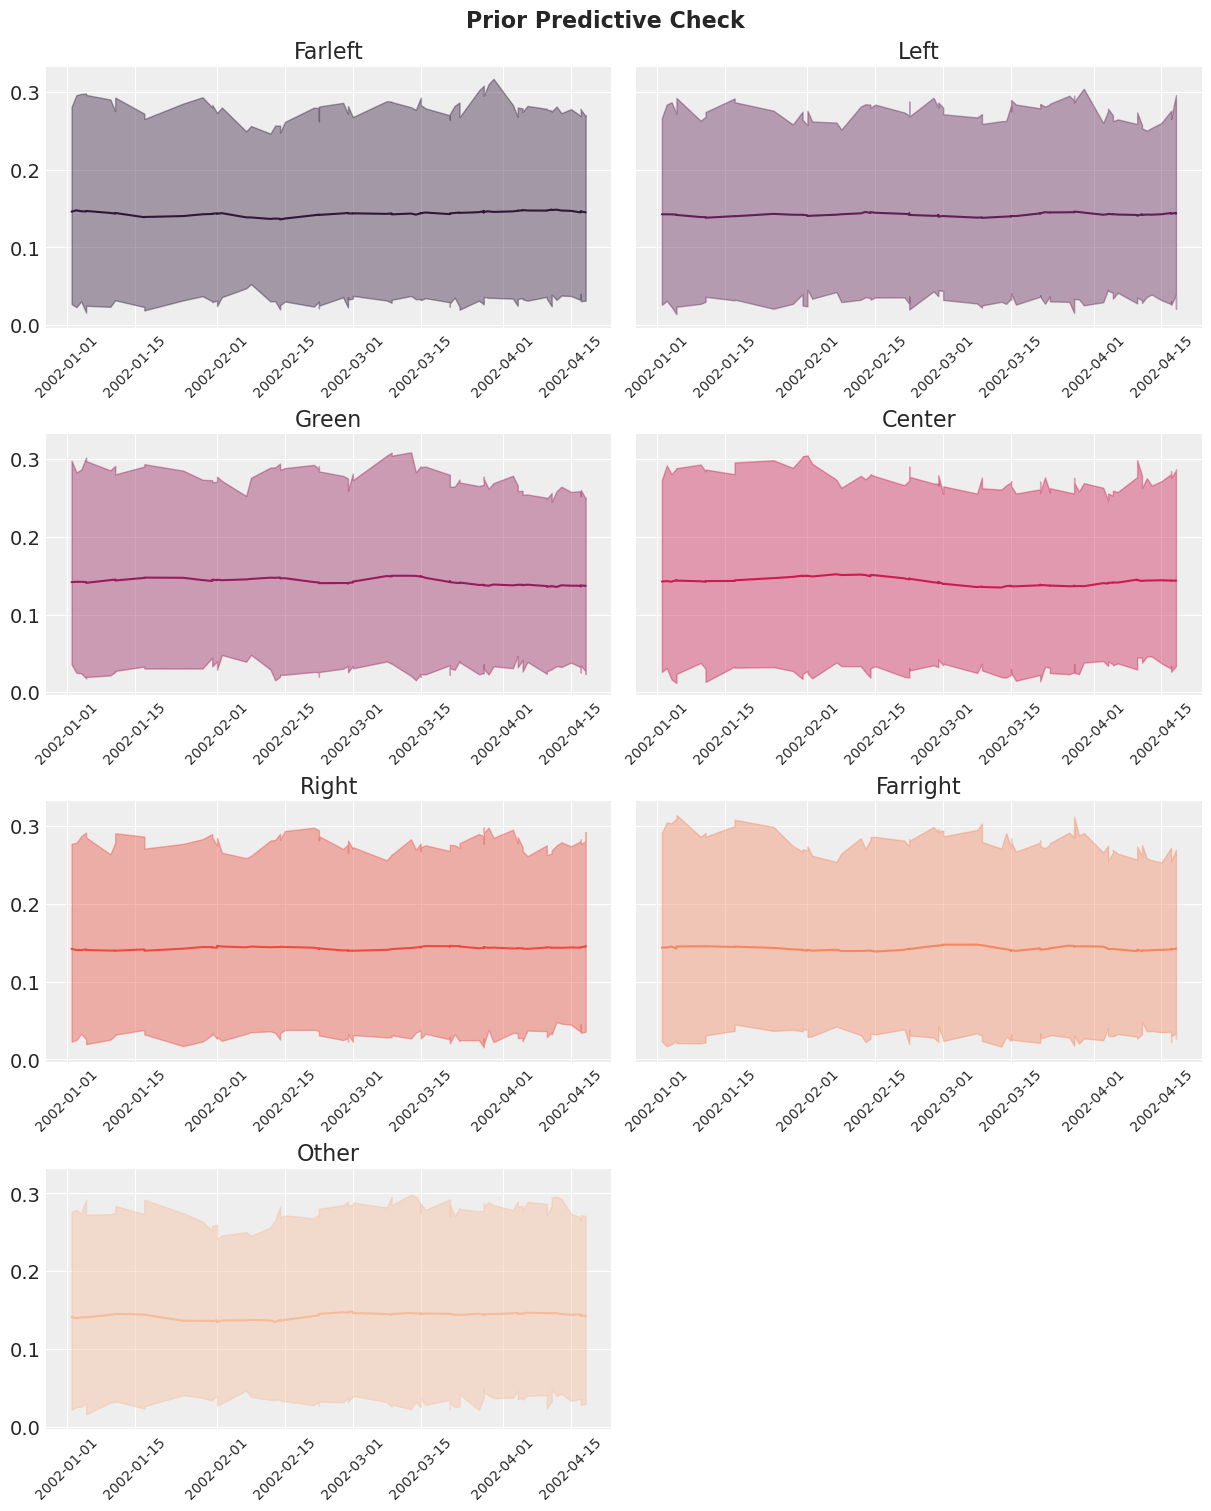

In [13]:
retrodictive_plot(
    idata_hierarchical.sel(
        elections="2002-04-21",
        observations=polls[polls.dateelection == "2002-04-21"].index,
    ),
    COORDS["parties_complete"],
    polls[polls.dateelection == "2002-04-21"],
    group="prior",
)

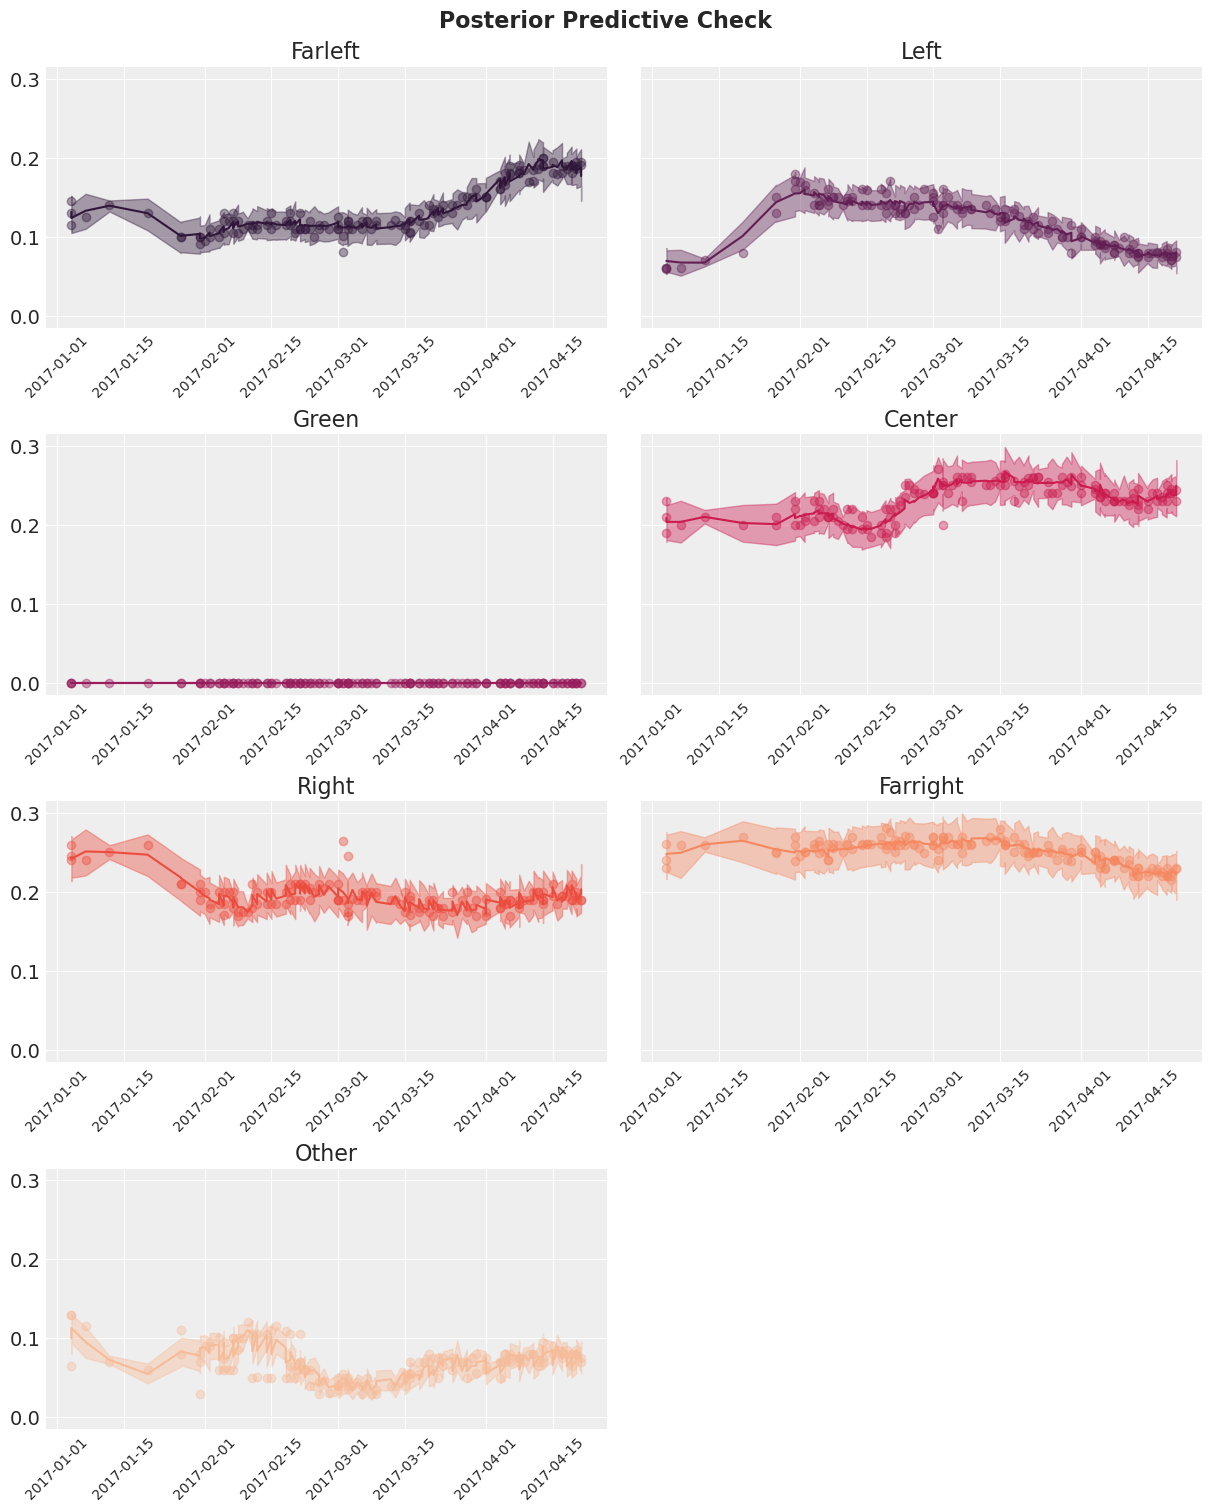

In [14]:
retrodictive_plot(
    idata_hierarchical.sel(
        elections="2017-04-23",
        observations=polls[polls.dateelection == "2017-04-23"].index,
    ),
    COORDS["parties_complete"],
    polls[polls.dateelection == "2017-04-23"],
    group="posterior",
)

In [15]:
estimated_days = np.tile(COORDS["countdown"][::-1], reps=len(COORDS["elections"]))

new_dates = []
for date in idata_hierarchical.posterior["elections"].data:
    new_dates.append(
        pd.date_range(
            periods=max(COORDS["countdown"]) + 1, end=date, freq="D"
        ).to_series()
    )

new_dates = pd.concat(new_dates).index

In [17]:
with m_hierarchical:
    pm.set_data(
        {
            "countdown_idx": estimated_days,
            "election_idx": np.repeat(
                np.arange(len(COORDS["elections"])), repeats=len(COORDS["countdown"])
            ),
            "pollster_idx": np.random.choice(pollster_id, size=len(estimated_days)),
            "observed_N": np.random.choice(
                polls["samplesize"].values, size=len(estimated_days)
            ),
            "observed_polls": np.ones(
                (len(estimated_days), len(COORDS["parties_complete"])), dtype=int
            ),  # just a placeholder
        }
    )
    ppc = pm.sample_posterior_predictive(
        idata_hierarchical, var_names=["time_effect", "popularity", "N_approve"]
    )

In [18]:
PREDICTION_COORDS = {"observations": new_dates}
PREDICTION_DIMS = {
    "time_effect": ["countdown", "parties_complete", "elections"],
    "popularity": ["observations", "parties_complete"],
    "N_approve": ["observations", "parties_complete"],
}

In [20]:
with m_hierarchical:
    arviz.from_pymc3_predictions(
        ppc,
        idata_orig=idata_hierarchical,
        inplace=True,
        coords=PREDICTION_COORDS,
        dims=PREDICTION_DIMS,
    )

In [21]:
%load_ext autoreload
%autoreload 2

In [23]:
polls.dateelection.unique()

array(['2002-04-21T00:00:00.000000000', '2007-04-22T00:00:00.000000000',
       '2012-04-22T00:00:00.000000000', '2017-04-23T00:00:00.000000000'],
      dtype='datetime64[ns]')

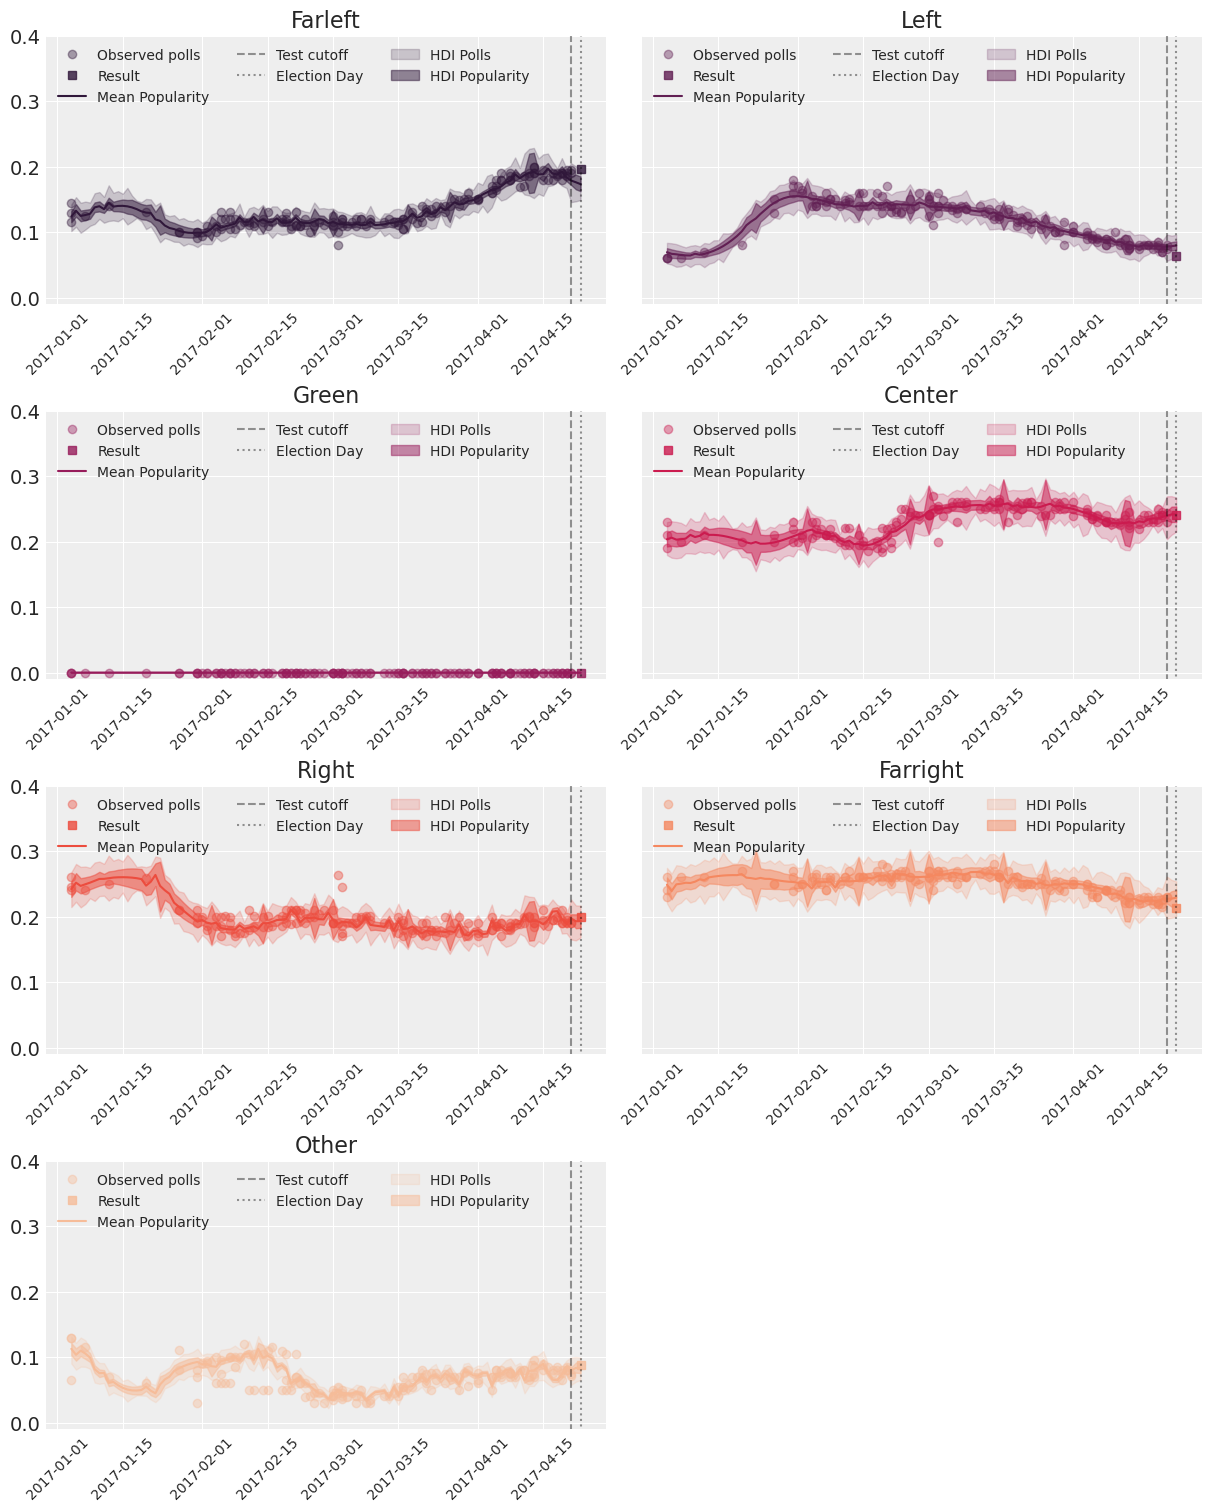

In [53]:
election_date = "2017-04-23"
polls_train = polls[polls.dateelection == election_date]
polls_test = pd.DataFrame()

predictive_plot(
    idata_hierarchical,
    COORDS["parties_complete"],
    election_date,
    results,
    polls_train,
    polls_test,
)

In [125]:
with pm.Model(coords=COORDS) as m_hierarchical:
    party_intercept = ZeroSumNormal(
        "party_intercept", sigma=0.1, dims="parties_complete"
    )
    party_intercept_shrinkage = pm.HalfNormal(
        "party_intercept_shrinkage", 0.1, dims="parties_complete"
    )
    party_election_intercept = ZeroSumNormal(
        "party_election_intercept",
        sigma=party_intercept_shrinkage[None, ...],
        dims=("elections", "parties_complete"),
        zerosum_axes=-1,
    )

    house_effects = ZeroSumNormal(
        "house_effects",
        sigma=0.1,
        dims=("pollsters", "parties_complete"),
        zerosum_axes=(0, 1),
    )
    house_effects_shrinkage = pm.HalfNormal("house_effects_shrinkage", 0.1)
    house_election_effects = ZeroSumNormal(
        "house_election_effects",
        sigma=1,
        dims=("pollsters", "parties_complete", "elections"),
        zerosum_axes=(0, 1),
    )

    lsd_intercept = pm.Normal("lsd_intercept", sigma=0.1, dims="elections")
    shrinkage = pm.HalfNormal("shrinkage", 0.1, dims="elections")
    raw_lsd = ZeroSumNormal(
        "raw_lsd_party", dims=("parties_complete", "elections"), zerosum_axes=0
    )
    sd = pm.Deterministic(
        "time_weight",
        aet.exp(lsd_intercept[None, :] + shrinkage[None, :] * raw_lsd),
        dims=("parties_complete", "elections"),
    )
    # shrinkage = pm.HalfNormal("shrinkage", 0.5)
    # sd = pm.HalfNormal("time_weight", shrinkage, dims="parties_complete")

    gp_basis_funcs, gp_basis_dim = make_gp_basis(
        time=COORDS["countdown"], gp_config=GP_CONFIG, key="parties"
    )
    raw_coefs = ZeroSumNormal(
        f"raw_time_coefs",
        sigma=sd[None, ...],
        dims=(gp_basis_dim, "parties_complete", "elections"),
        zerosum_axes=1,
    )
    gps = pm.Deterministic(
        "time_effect",
        aet.tensordot(gp_basis_funcs, raw_coefs, axes=(1, 0)),
        dims=("countdown", "parties_complete", "elections"),
    )

    # data
    election_idx = pm.Data("election_idx", election_id, dims="observations")
    pollster_idx = pm.Data("pollster_idx", pollster_id, dims="observations")
    countdown_idx = pm.Data("countdown_idx", countdown_id, dims="observations")
    observed_N = pm.Data("observed_N", polls["samplesize"].values, dims="observations")
    observed_polls = pm.Data(
        "observed_polls",
        polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    # regression
    mu = (
        party_intercept
        + party_election_intercept[election_idx]
        + house_effects[pollster_idx]
        + house_effects_shrinkage
        * house_election_effects[pollster_idx, :, election_idx]
        + gps[countdown_idx, :, election_idx]
    )
    popularity = pm.Deterministic(
        "popularity",
        aet.nnet.softmax(mu),
        dims=("observations", "parties_complete"),
    )

    # likelihood
    N_approve = pm.DirichletMultinomial(
        "N_approve",
        a=aet.exp(mu),
        n=observed_N,
        observed=observed_polls,
        dims=("observations", "parties_complete"),
    )
    # https://mc-stan.org/docs/2_27/stan-users-guide/bayesian-measurement-error-model.html

    prior_checks = pm.sample_prior_predictive(
        var_names=["time_effect", "popularity", "N_approve"]
    )
    idata_hierarchical = pm.sample(return_inferencedata=True)
    post_checks = pm.sample_posterior_predictive(
        idata_hierarchical, var_names=["time_effect", "popularity", "N_approve"]
    )
    idata_hierarchical.extend(
        arviz.from_pymc3(prior=prior_checks, posterior_predictive=post_checks)
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_time_coefs, raw_lsd_party, shrinkage, lsd_intercept, house_election_effects, house_effects_shrinkage, house_effects, party_election_intercept, party_intercept_shrinkage, party_intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 371 seconds.


0, dim: observations, 436 =? 436
1, dim: parties_complete, 1 =? 7


The number of effective samples is smaller than 25% for some parameters.


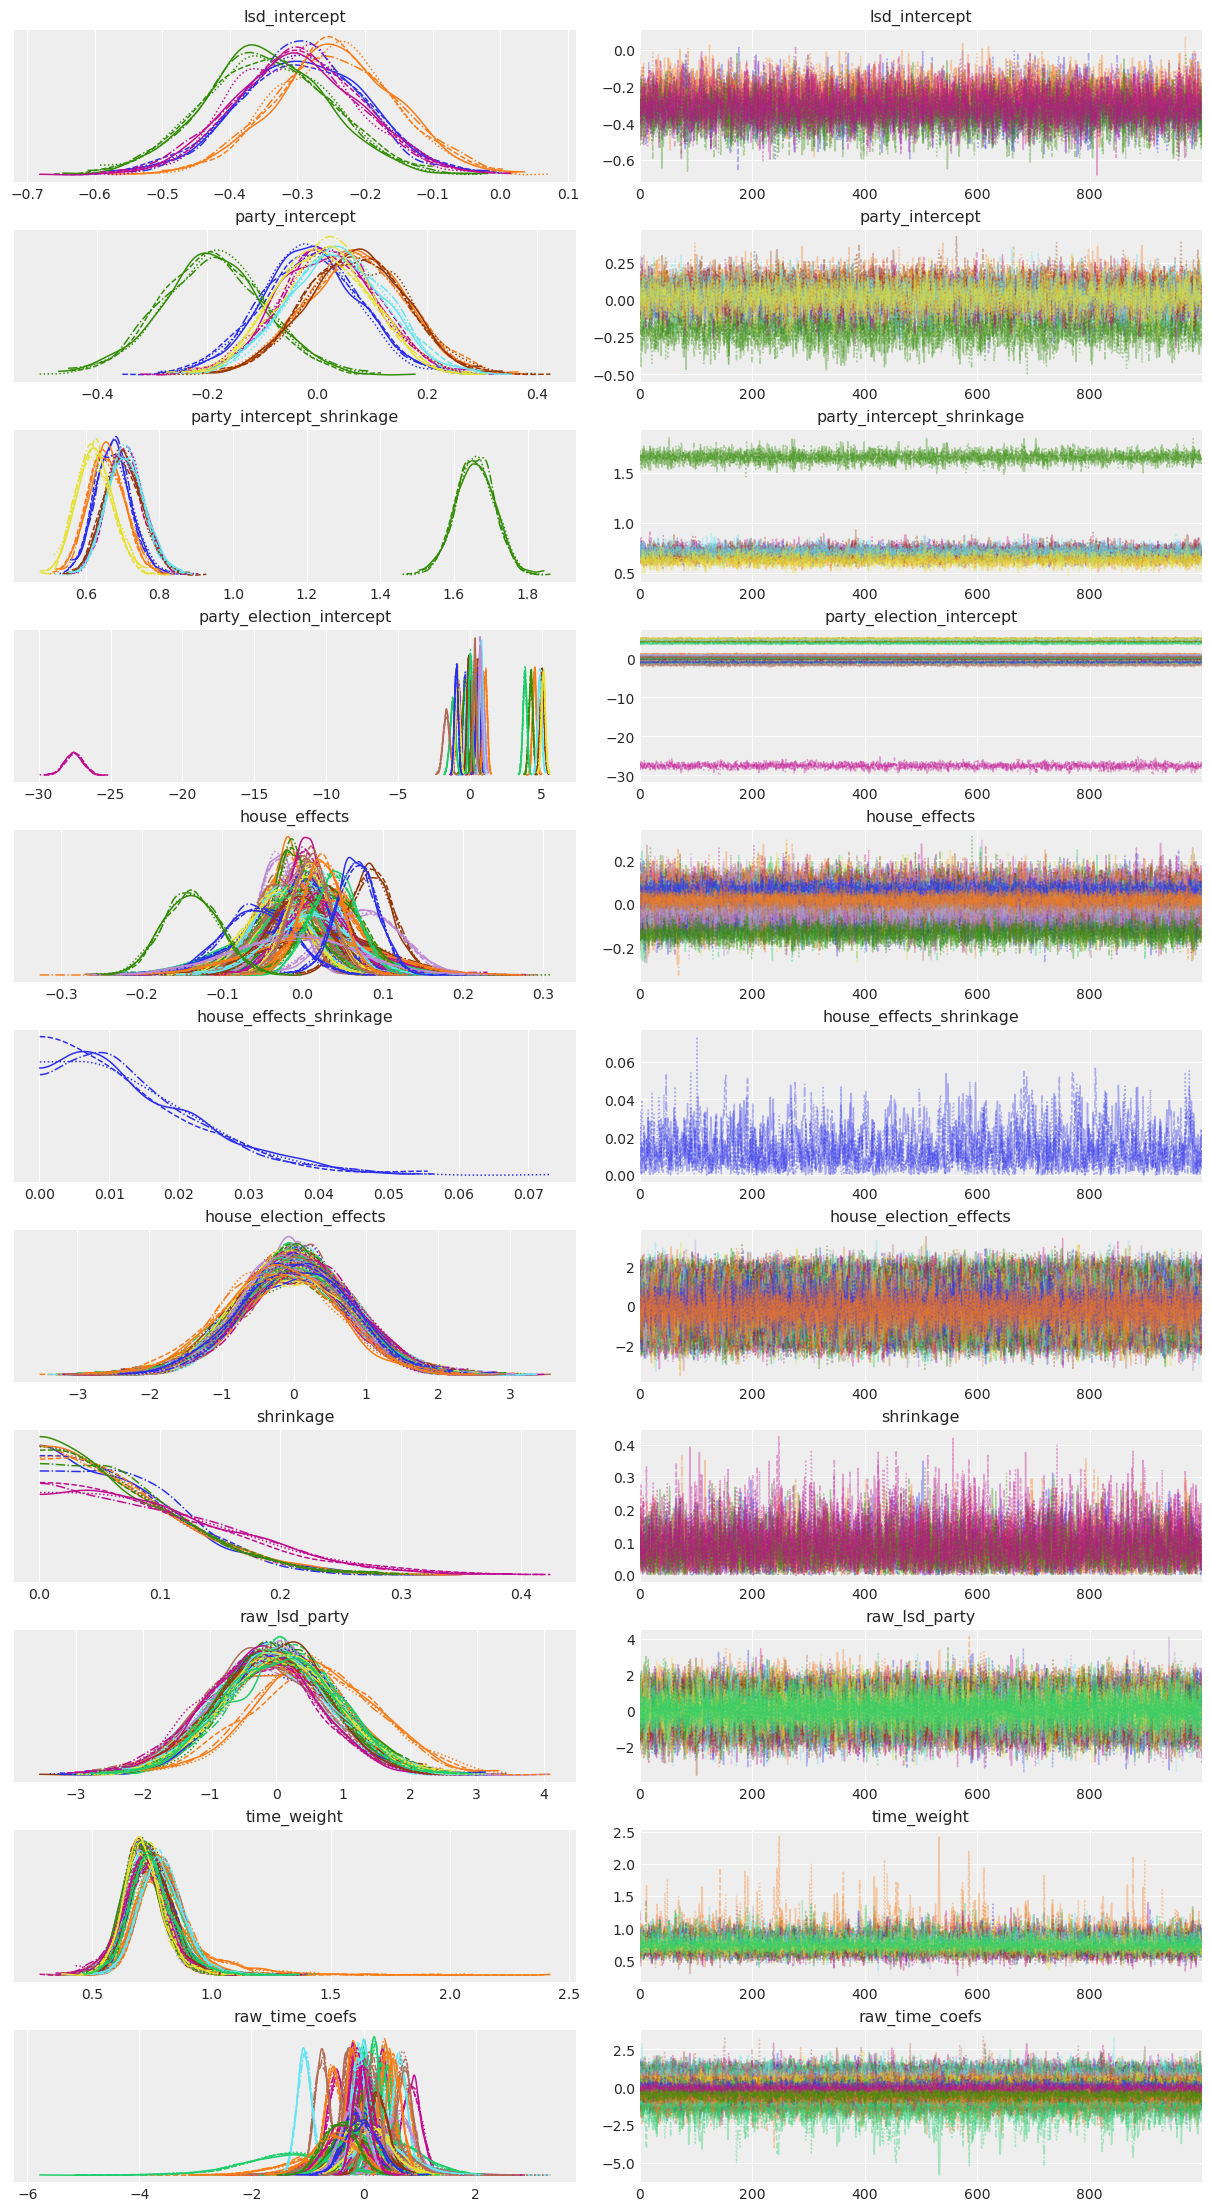

In [126]:
arviz.plot_trace(idata_hierarchical, var_names=["~time_effect", "~popularity"]);

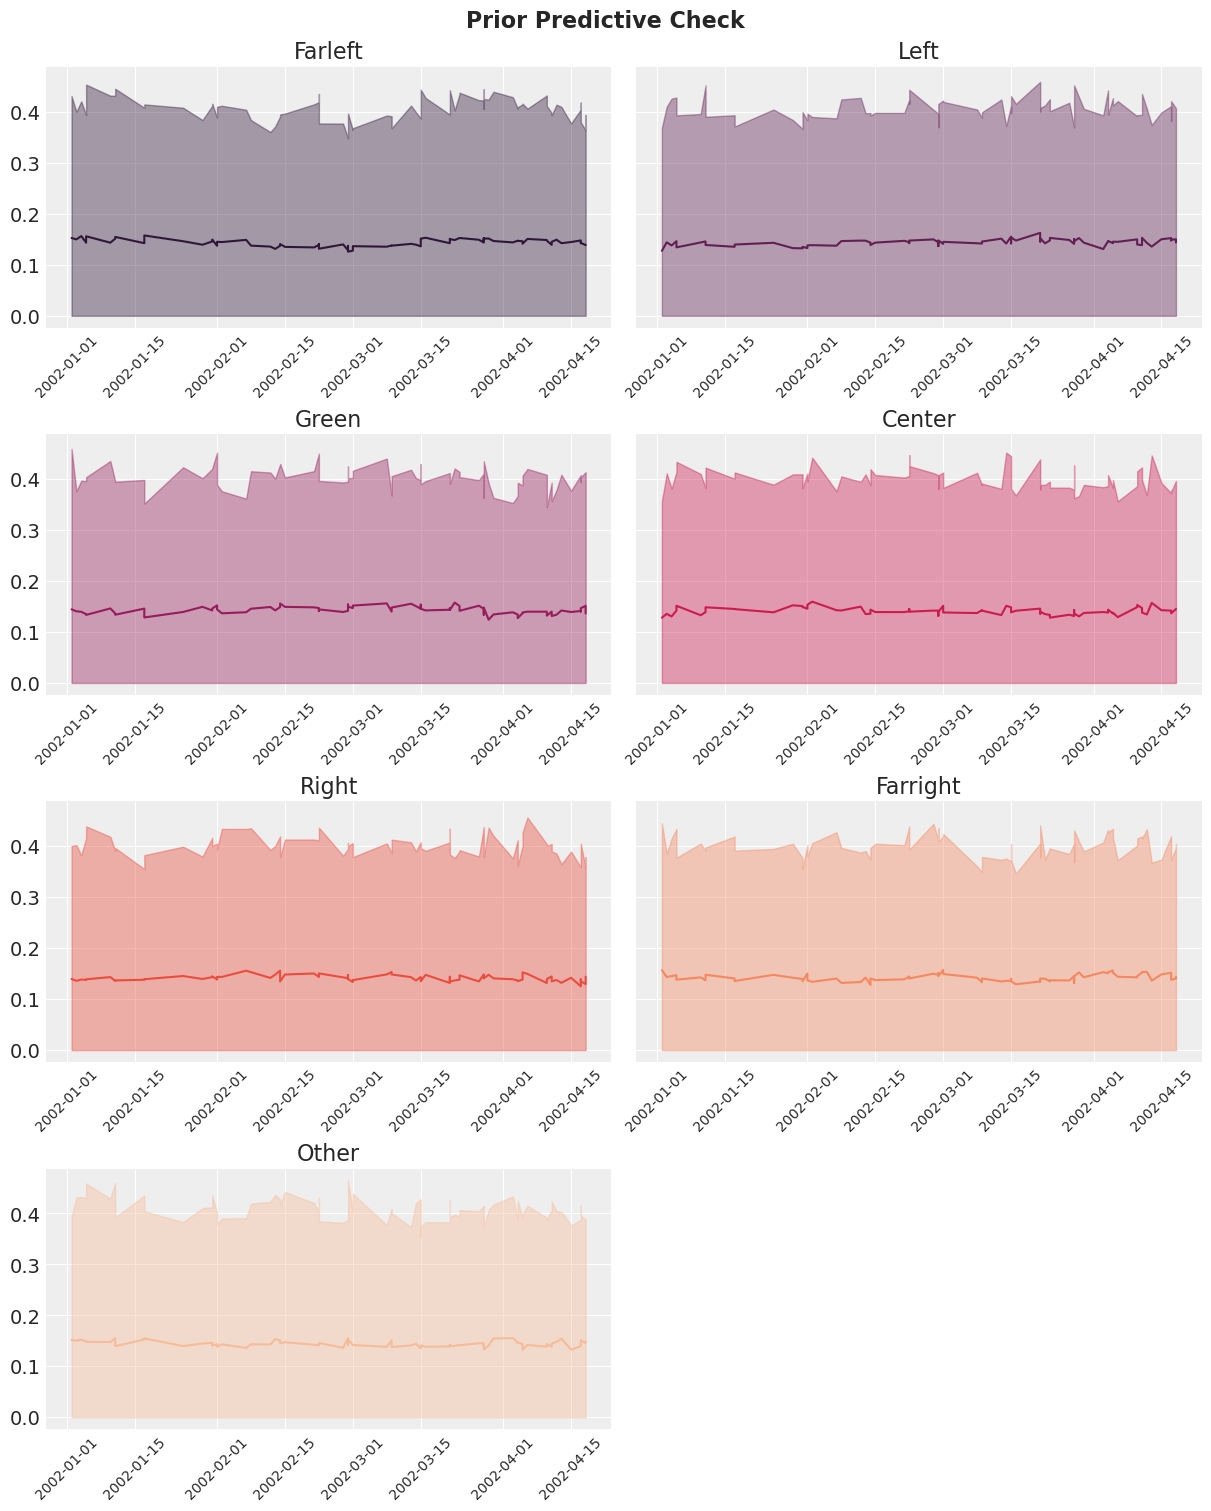

In [127]:
retrodictive_plot(
    idata_hierarchical.sel(
        elections="2002-04-21",
        observations=polls[polls.dateelection == "2002-04-21"].index,
    ),
    COORDS["parties_complete"],
    polls[polls.dateelection == "2002-04-21"],
    group="prior",
)

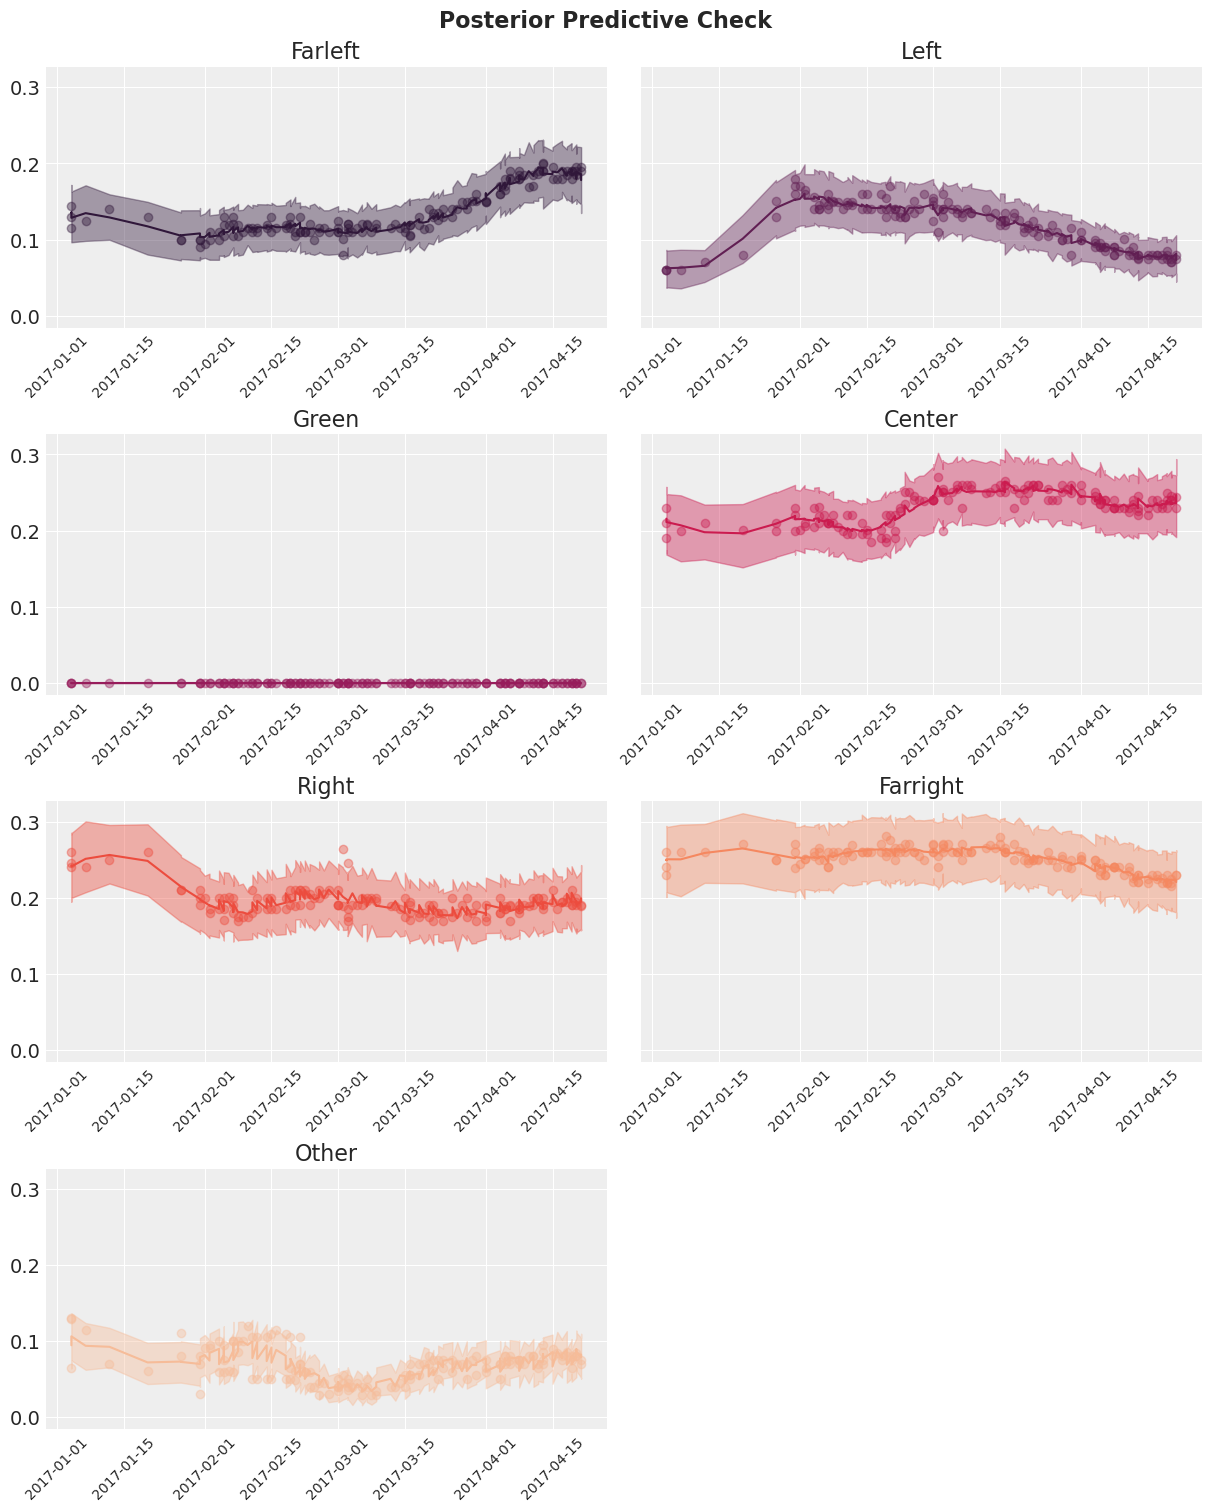

In [128]:
retrodictive_plot(
    idata_hierarchical.sel(
        elections="2017-04-23",
        observations=polls[polls.dateelection == "2017-04-23"].index,
    ),
    COORDS["parties_complete"],
    polls[polls.dateelection == "2017-04-23"],
    group="posterior",
)

In [129]:
estimated_days = np.tile(COORDS["countdown"][::-1], reps=len(COORDS["elections"]))

new_dates = []
for date in idata_hierarchical.posterior["elections"].data:
    new_dates.append(
        pd.date_range(
            periods=max(COORDS["countdown"]) + 1, end=date, freq="D"
        ).to_series()
    )

new_dates = pd.concat(new_dates).index

In [130]:
with m_hierarchical:
    pm.set_data(
        {
            "countdown_idx": estimated_days,
            "election_idx": np.repeat(
                np.arange(len(COORDS["elections"])), repeats=len(COORDS["countdown"])
            ),
            "pollster_idx": np.random.choice(pollster_id, size=len(estimated_days)),
            "observed_N": np.random.choice(
                polls["samplesize"].values, size=len(estimated_days)
            ),
            "observed_polls": np.ones(
                (len(estimated_days), len(COORDS["parties_complete"])), dtype=int
            ),  # just a placeholder
        }
    )
    ppc = pm.sample_posterior_predictive(
        idata_hierarchical, var_names=["time_effect", "popularity", "N_approve"]
    )

In [131]:
PREDICTION_COORDS = {"observations": new_dates}
PREDICTION_DIMS = {
    "time_effect": ["countdown", "parties_complete", "elections"],
    "popularity": ["observations", "parties_complete"],
    "N_approve": ["observations", "parties_complete"],
}

In [132]:
with m_hierarchical:
    arviz.from_pymc3_predictions(
        ppc,
        idata_orig=idata_hierarchical,
        inplace=True,
        coords=PREDICTION_COORDS,
        dims=PREDICTION_DIMS,
    )

In [83]:
polls.dateelection.unique()

array(['2002-04-21T00:00:00.000000000', '2007-04-22T00:00:00.000000000',
       '2012-04-22T00:00:00.000000000', '2017-04-23T00:00:00.000000000'],
      dtype='datetime64[ns]')

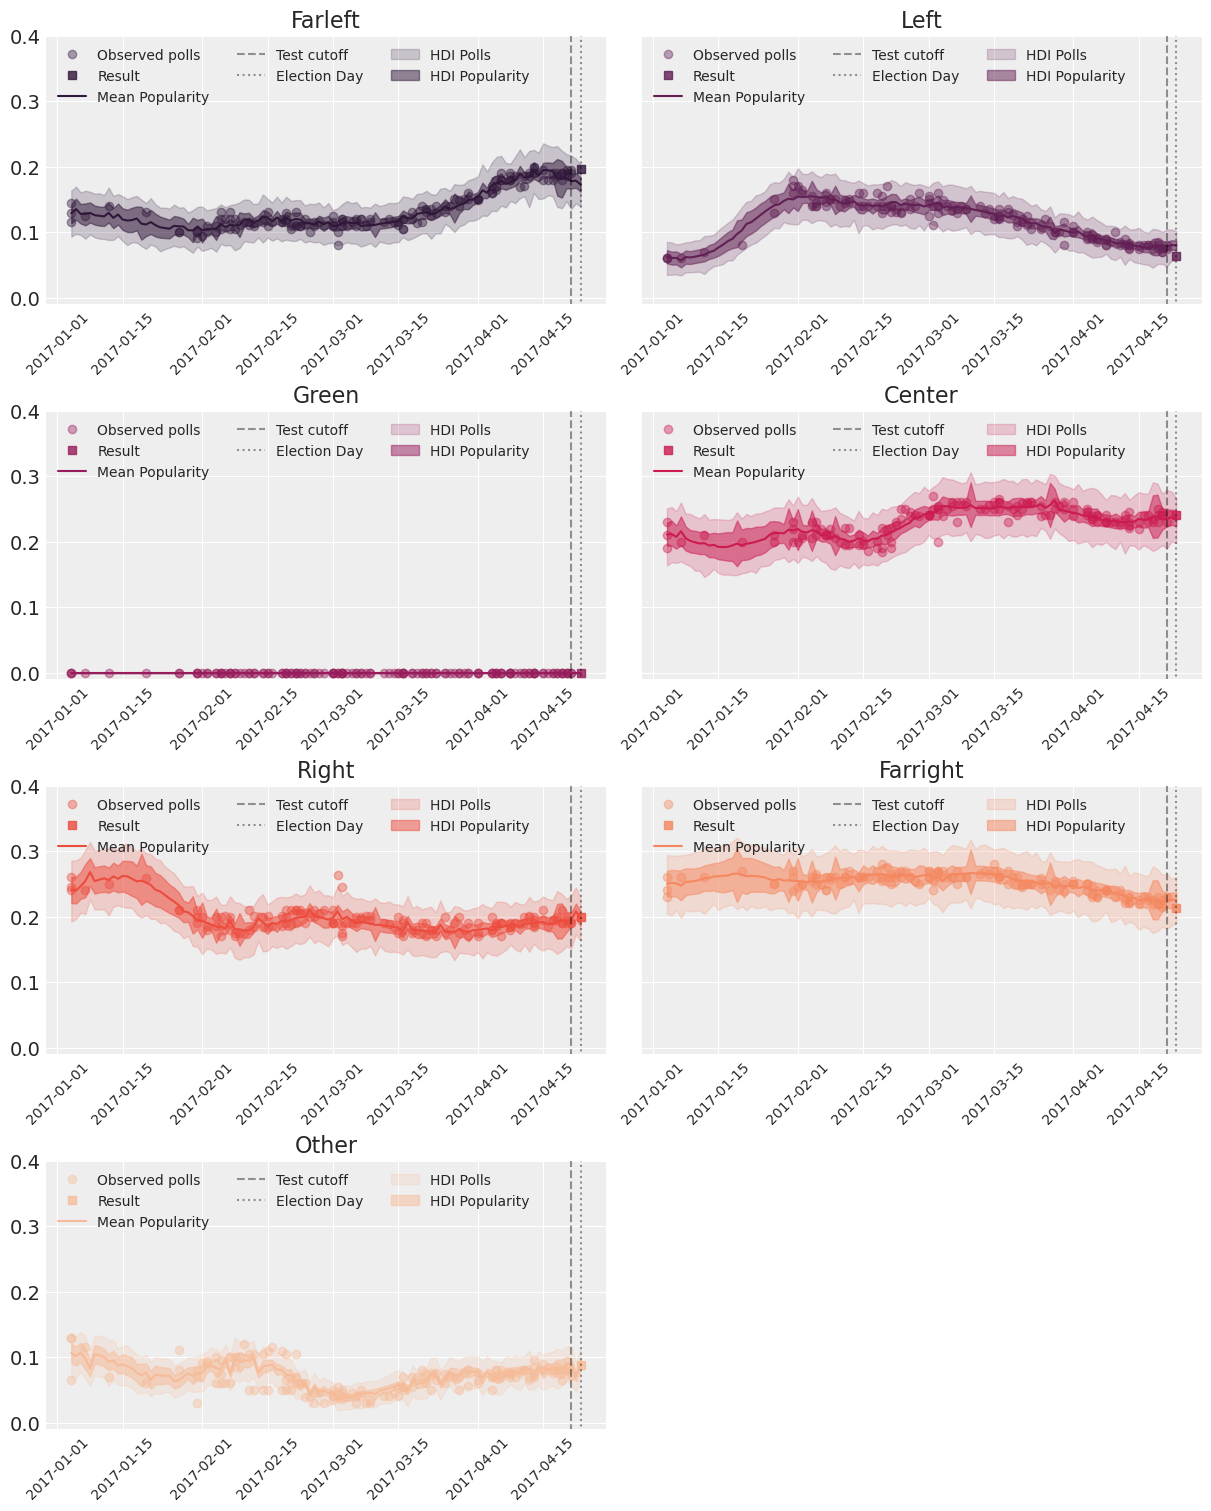

In [141]:
election_date = "2017-04-23"
polls_train = polls[polls.dateelection == election_date]
polls_test = pd.DataFrame()

predictive_plot(
    idata_hierarchical,
    COORDS["parties_complete"],
    election_date,
    results,
    polls_train,
    polls_test,
)

In [11]:
# add popularity and econ variables as predictors